In [1]:
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing


def haversine(pointA,pointB):
    lon1, lat1, lon2, lat2  = map(math.radians, [pointA[1], pointA[0],pointB[1],pointB[0]])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    #base = 6371 * c
    base = 3961 * c
    return base

def lookup(s):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date) for date in s.unique()}
    return s.map(dates)

In [2]:
%%time
import pandas as pd
import numpy as np
import datetime
import os
import math 
from os import walk
import calmap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

%matplotlib inline


CPU times: user 1.51 s, sys: 459 ms, total: 1.97 s
Wall time: 2.59 s


In [3]:
%%time
d1090_raw = pd.read_csv('dump1090.dat',names=['msg_type','tx_type','session_id','aircraft_id','hex_id','flight_id','gen_date','gen_time','log_date','log_time','callsign','altitude','ground_speed','track','lat','lon','vdelta','squawk','alert','emergrency','spi','on_ground'])
print("raw rows:", str(d1090_raw.msg_type.count()))

raw rows: 5262104
CPU times: user 21.6 s, sys: 4.49 s, total: 26.1 s
Wall time: 26.7 s


In [4]:
%%time
sf = d1090_raw[d1090_raw.lat.notnull()][['hex_id','gen_date','gen_time','log_date','log_time','lat','lon','altitude','ground_speed','track']]
print("Position Rows:", str(sf.hex_id.count()))

Position Rows: 449584
CPU times: user 444 ms, sys: 713 ms, total: 1.16 s
Wall time: 1.15 s


In [5]:
%%time
sf['log_time'] = lookup(sf.log_date + " " + sf.log_time)
sf['gen_time'] = lookup(sf.gen_date + " " + sf.gen_time)
sf.drop(['log_date','gen_date'], axis=1,inplace=True)
sf.sort_values(['hex_id','gen_time'],inplace=True)

CPU times: user 1min 16s, sys: 834 ms, total: 1min 17s
Wall time: 1min 17s


In [6]:
pd.options.mode.chained_assignment = None 

In [7]:
%%time
sf['pointB'] = tuple(zip(sf['lat'],sf['lon']) )
sf['pointA'] = tuple(zip(sf.lat.shift(1),sf.lon.shift(1)) )
sf['posDelta_mi'] = sf.apply(lambda x: haversine(x['pointA'],x['pointB']),axis=1)
sf['bearing_calc'] = sf.apply(lambda x: calculate_initial_compass_bearing(x['pointA'],x['pointB']),axis=1)
sf['bearingDelta'] = sf.bearing_calc.shift(1) - sf['bearing_calc']
sf.drop(['pointA','pointB'], axis=1,inplace=True)
sf['timeDelta_sec']=abs(pd.to_datetime( sf['gen_time'].shift(1)) - pd.to_datetime( sf['gen_time'])).astype('timedelta64[ms]')/1000
sf['speedCalc'] = sf.posDelta_mi/(sf.timeDelta_sec)*3600

CPU times: user 2min 16s, sys: 865 ms, total: 2min 17s
Wall time: 2min 17s


In [8]:
sf.head()

,hex_id,gen_time,log_time,lat,lon,altitude,ground_speed,track,posDelta_mi,bearing_calc,bearingDelta,timeDelta_sec,speedCalc
5036593,06A100,2018-05-07 19:40:42.262,2018-05-07 19:40:42.286,35.05820,-83.68892,26275.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5041036,06A100,2018-05-07 19:41:02.963,2018-05-07 19:41:02.984,35.02176,-83.70472,25600.0,NaN,NaN,2.673221,199.549504,NaN,20.701,464.885555
5041262,06A100,2018-05-07 19:41:03.825,2018-05-07 19:41:03.855,35.02027,-83.70518,25575.0,NaN,NaN,0.106249,194.188754,5.360750,0.862,443.729771
5041740,06A100,2018-05-07 19:41:05.888,2018-05-07 19:41:05.927,35.01636,-83.70632,25525.0,NaN,NaN,0.277907,193.429872,0.758882,2.063,484.956583
5041967,06A100,2018-05-07 19:41:06.813,2018-05-07 19:41:06.854,35.01473,-83.70678,25500.0,NaN,NaN,0.115657,193.014254,0.415618,0.925,450.123178


## Look at speeds

In [9]:
p95 = sf.groupby('hex_id')['speedCalc'].quantile(0.95)
p95.sort_values(ascending=False,inplace=True)
p95

hex_id
A05353    1749.124677
A32449    1047.759584
A1A523    1035.124582
AA90A0    1022.862393
A1AC91     986.388010
AB321C     984.513947
A25188     856.220156
A9D5E7     805.679613
A955C8     792.453384
A8AF5F     789.863434
A5A888     785.583780
A35E5B     775.585399
A1FFB3     759.750791
A8D6DE     751.024682
A3965C     737.240180
A992E4     731.757527
A7618F     728.129079
0D02F7     724.448321
A86671     722.732584
A90BDB     721.538894
A0F91D     719.975651
AC72E4     719.812909
A8FAA6     716.604655
AB2C0C     716.509785
A4D905     710.941759
A858F3     710.721828
A252AE     710.607598
AA7A61     705.114171
A972D3     705.087029
AA37C1     704.955122
             ...     
A12730     190.167686
AB56A4     189.009660
A66D6A     187.301398
A663FB     178.066171
A575B3     176.771981
ACD837     174.629648
A81C52     173.646153
A375F1     172.579235
A7A8F8     171.205069
AD927C     166.644278
A824DB     163.443139
A2B537     154.151601
ACE31A     145.916031
A0E3F9     141.573678
A89

## Look at speeds

In [10]:
p95 = sf.groupby('hex_id')['speedCalc'].quantile(0.95)
p95.sort_values(ascending=False,inplace=True)
p95

hex_id
A05353    1749.124677
A32449    1047.759584
A1A523    1035.124582
AA90A0    1022.862393
A1AC91     986.388010
AB321C     984.513947
A25188     856.220156
A9D5E7     805.679613
A955C8     792.453384
A8AF5F     789.863434
A5A888     785.583780
A35E5B     775.585399
A1FFB3     759.750791
A8D6DE     751.024682
A3965C     737.240180
A992E4     731.757527
A7618F     728.129079
0D02F7     724.448321
A86671     722.732584
A90BDB     721.538894
A0F91D     719.975651
AC72E4     719.812909
A8FAA6     716.604655
AB2C0C     716.509785
A4D905     710.941759
A858F3     710.721828
A252AE     710.607598
AA7A61     705.114171
A972D3     705.087029
AA37C1     704.955122
             ...     
A12730     190.167686
AB56A4     189.009660
A66D6A     187.301398
A663FB     178.066171
A575B3     176.771981
ACD837     174.629648
A81C52     173.646153
A375F1     172.579235
A7A8F8     171.205069
AD927C     166.644278
A824DB     163.443139
A2B537     154.151601
ACE31A     145.916031
A0E3F9     141.573678
A89

## Look at turns

In [12]:
p95 = sf.groupby('hex_id')['bearingDelta'].quantile(0.95)
p95.sort_values(ascending=False,inplace=True)
p95.head()

hex_id
A38223    359.528147
ACBEA2    358.963801
ACA220    358.931861
A1F11D    357.266025
A2B294    357.234231
Name: bearingDelta, dtype: float64

## Plot all tracks

In [84]:
p95.count()/6



124.33333333333333

i = 0
plt.figure(figsize=(100,60))
for idx in p95.index:
    i = i + 1
    pt= sf[sf.hex_id == idx]
    ax = plt.subplot(125,6,i)
    ax.set_title(idx)
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(x=pt.lon, y=pt.lat, alpha=0.4)
plt.show()

i = 0
for idx in p95.index:
    print(idx)
    plottrack = sf[sf.hex_id == idx]
    plottrack.plot(kind="scatter", x="lon", y="lat", alpha=0.4,figsize=(2,2),subplots=(4,4,i+1))
    plt.show()

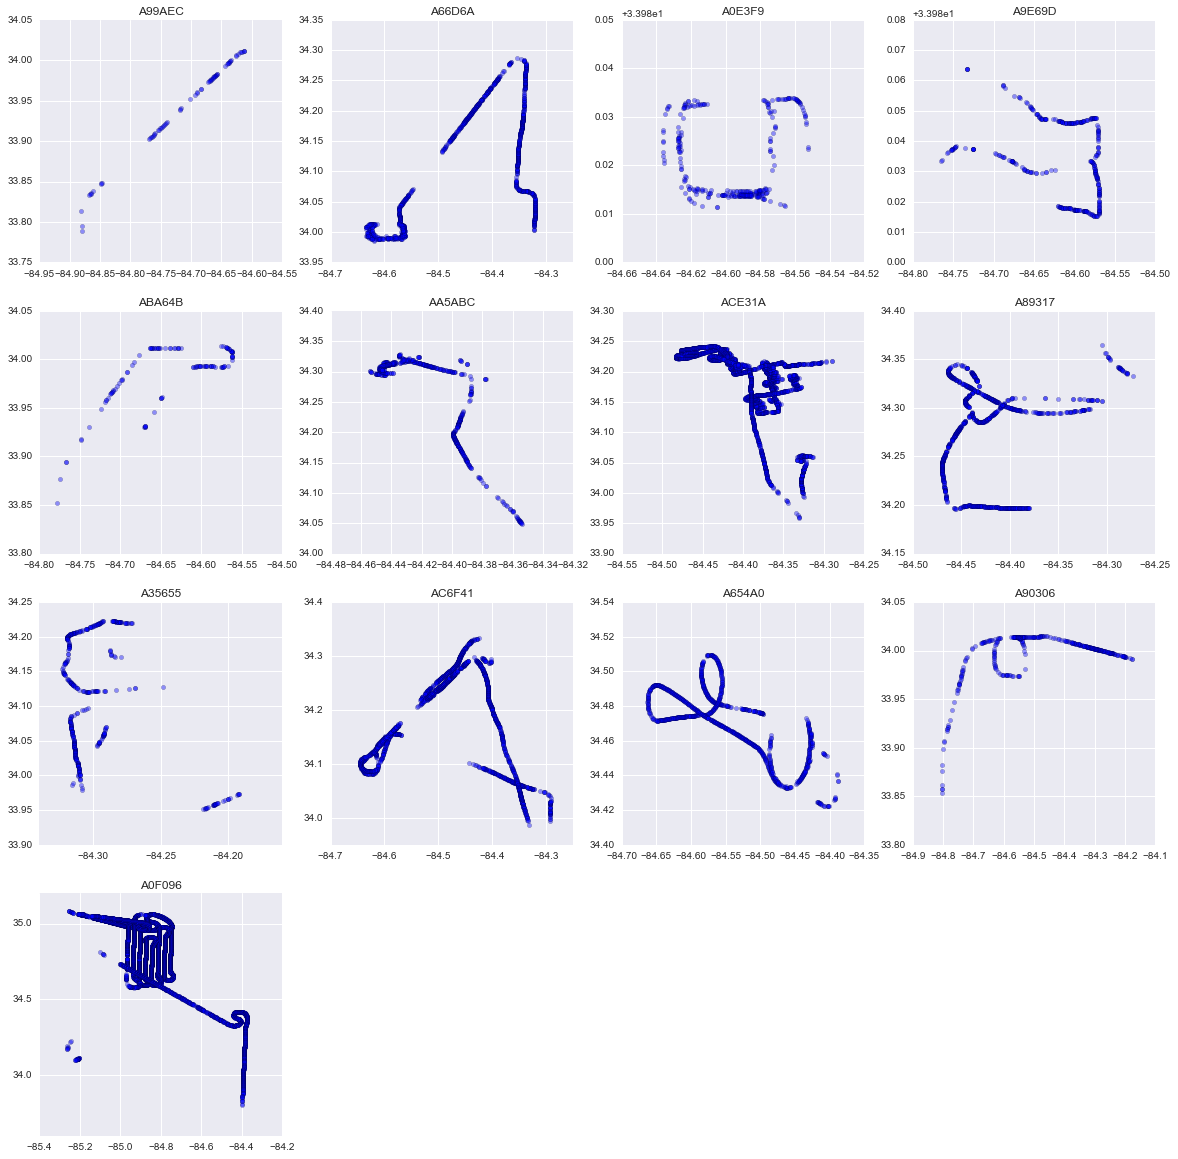

In [83]:
iset = ['A99AEC','A66D6A','A0E3F9','A9E69D','ABA64B','AA5ABC','ACE31A','A89317','A35655','AC6F41','A654A0','A90306','A0F096']
i = 0
plt.figure(figsize=(20,20))
for idx in iset:
    i = i + 1
    pt= sf[sf.hex_id == idx]
    ax = plt.subplot(4,4,i)
    ax.set_title(idx)
    ax.scatter(x=pt.lon, y=pt.lat, alpha=0.4)
plt.show()


In [ ]:
unique_hex = sf.groupby('hex_id')['lat'].count()
unique_hex.sort_values(ascending=False,inplace=True)
unique_hex.head()

# Plot the Results with Google Maps

In [95]:
hex_plot = 'AC6F41'
track = sf[sf.hex_id == hex_plot ]
track.sort_values('gen_time',inplace=True)
centroid_lat = track.lat.mean()
centroid_lon = track.lon.mean()
track.head()

,hex_id,gen_time,log_time,lat,lon,altitude,ground_speed,track,posDelta_mi,bearing_calc,bearingDelta,timeDelta_sec,speedCalc
1893022,AC6F41,2018-05-07 14:29:52.368,2018-05-07 14:29:52.395,33.99454,-84.29384,3500.0,NaN,NaN,25.564326,170.023384,57.054146,12399.352,7.422289
1893985,AC6F41,2018-05-07 14:29:57.795,2018-05-07 14:29:57.845,33.99779,-84.29372,3600.0,NaN,NaN,0.224786,1.753357,168.270027,5.427,149.111673
1894165,AC6F41,2018-05-07 14:29:58.825,2018-05-07 14:29:58.881,33.99838,-84.29372,3600.0,NaN,NaN,0.040788,0.000000,1.753357,1.030,142.560594
1895239,AC6F41,2018-05-07 14:30:05.204,2018-05-07 14:30:05.227,34.00218,-84.29361,3600.0,NaN,NaN,0.262779,1.374711,-1.374711,6.379,148.299856
1895834,AC6F41,2018-05-07 14:30:08.255,2018-05-07 14:30:08.283,34.00404,-84.29358,3700.0,NaN,NaN,0.128598,0.766053,0.608658,3.051,151.737969


In [96]:
from gmplot import gmplot
gmap = gmplot.GoogleMapPlotter(centroid_lat, centroid_lon, 10)
gmap.plot(lats=track.lat,lngs=track.lon, color='cornflowerblue', edge_width=1)
gmap.scatter( lats=track.lat,lngs=track.lon,color= 'red', size=40, marker=False)
fname = hex_plot + ".html"
print(fname)
gmap.draw(fname)

AC6F41.html
